<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Результат-полученной-модели" data-toc-modified-id="Результат-полученной-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результат полученной модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача проекта заключается в построении модели, которая по фотографии определит приблизительный возраст человека.  
Проект включает в себя следующие этапы:
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

Необходимо получить значение MAE на тестовой выборке не больше 8.

## Импорт библиотек

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

SEED = 777

## Исследовательский анализ данных

Загрузим датасет, сохраним в переменной и выведем 5 случайных строк датасета:

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.sample(5)

,file_name,real_age
77,000077.jpg,14
5917,005918.jpg,24
1989,001989.jpg,55
6542,006546.jpg,26
1875,001875.jpg,26


Выведем размер датасета:

In [3]:
df.shape

(7591, 2)

Посмотрим общую информацию о датасете:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков в данных нет. Типы данных соответствуют ожидаемым.

In [5]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Возраст людей на фото от 1 до 100 лет, средний возраст 31 год, медиана 29 лет - каких-либо выбросов и аномалий не наблюдается, то есть числовые данные соответствуют ожидаемым.

Построим гистограмму распределения возраста в датасете:

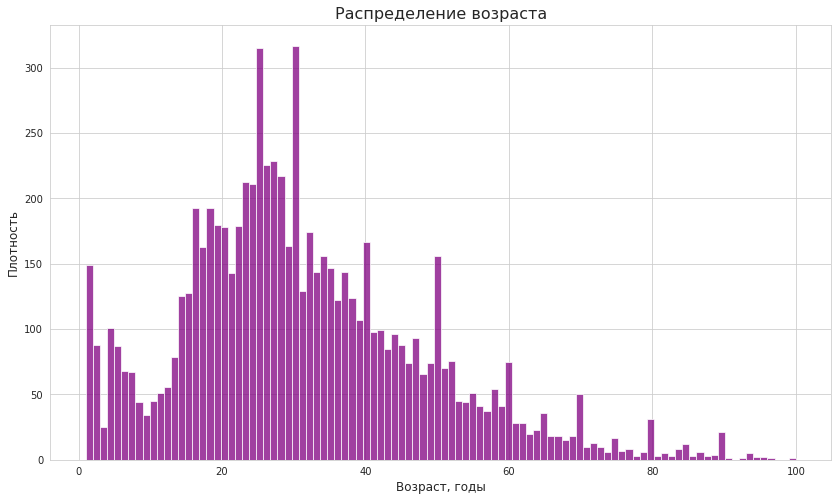

In [6]:
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')
sns.histplot(df['real_age'], bins=100, color='purple')
plt.xlabel('Возраст, годы', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.title('Распределение возраста', fontsize=16)
plt.show()

Исходя из полученной гистограммы, можно отметить, что:
- данные возраста находятся в диапазоне значений от 1 до 100 лет.
- в данных присутствуют 2 всплеска - в начале и середине выборки;
- пик распределения приходится на возраст 30-35 лет;
- на гистограмме присутствуют всплески в возрастах от 30 до 90 лет с шагом в каждые 10 лет, скорее всего из-за округления возраста.

Для извлечения изображений используем динамическую загрузку данных с помощью загрузчика ImageDataGenerator со следующими параметрами:

In [7]:
%%time
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.
CPU times: user 569 ms, sys: 361 ms, total: 930 ms
Wall time: 1min 28s


In [8]:
features, target = next(datagen_flow)

Выведем первые 16 фото датасета:

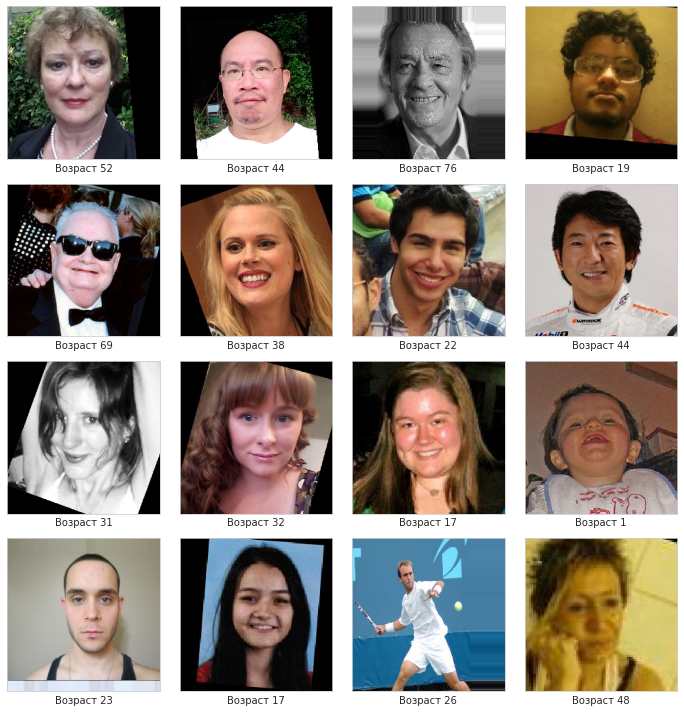

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(f'Возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На полученных фотографиях, можно увидеть фото как детей, так и пожилых людей. Попадаются фото и чернобелые, и цветные. Большая часть фото - лица крупным планом, но также есть фото людей в полный рост (фото с теннисистом). Также с некоторыми фото проводились преобразования - кропы, повороты изображения. У части людей частично лицо скрыто очками.

## Обучение модели

Далее непосредственно построим и обучим свёрточную нейронную сеть на нашем датасете:

```python
def load_train(path):
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.25
    )
    df = pd.read_csv(f'{path}/labels.csv', header=0)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED)
    return train_gen_flow
    
def load_test(path='/datasets/faces'):
    test_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    validation_split=0.25
    )
    df = pd.read_csv(f'{path}/labels.csv', header=0)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=SEED)
    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    print(model.summary())              
    return model

def train_model(model, train_data, test_data, 
               batch_size=None,
               epochs=8,
               steps_per_epoch=None, 
               validation_steps=None):
               
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
              
    return model

```

## Результат полученной модели

Выведем получившиеся архитектуру свёрточной сети и метрику качества MAE:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
=================================================================
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 49s - loss: 238.6160 - mae: 11.2211 - val_loss: 583.4276 - val_mae: 19.1608
Epoch 2/8
178/178 - 39s - loss: 84.1967 - mae: 7.0308 - val_loss: 448.9670 - val_mae: 16.1005
Epoch 3/8
178/178 - 39s - loss: 58.0444 - mae: 5.8138 - val_loss: 363.8299 - val_mae: 14.2587
Epoch 4/8
178/178 - 38s - loss: 47.6081 - mae: 5.2287 - val_loss: 129.7543 - val_mae: 8.5714
Epoch 5/8
178/178 - 38s - loss: 40.8969 - mae: 4.8273 - val_loss: 84.0278 - val_mae: 6.9637
Epoch 6/8
178/178 - 39s - loss: 31.4379 - mae: 4.2519 - val_loss: 75.5593 - val_mae: 6.6315
Epoch 7/8
178/178 - 39s - loss: 27.7369 - mae: 4.0315 - val_loss: 73.0654 - val_mae: 6.3567
Epoch 8/8
178/178 - 38s - loss: 24.1110 - mae: 3.7416 - val_loss: 63.0451 - val_mae: 6.0238

60/60 - 10s - loss: 63.7967 - mae: 6.0451
Test MAE: 6.0451

```

Метрика качества МАЕ полученной свёрточной нейронной сети равна 6.0451, что удовлетворяет требованиям проекта.

## Анализ обученной модели

В рамках данного проекта была поставлена задача построить модель системы компьютерного зрения, которая по фотографии могла бы определить приблизительный возраст человека. Критерием выполнения задачи являлась метрика качества МАЕ, которая на тестовой выборке должна быть не более 8.

Для решения поставленной задачи были выполнены следующие этапы:
- Проведение исследовательского анализа набора фотографий.
- Подготовка данных к обучению.
- Обучение нейронной сети и расчет её качества.

В результате была получена нейронная сеть со следующей архитектурой:
- предобученная свёрточная нейросеть ResNet50 с выключенной "головой" сети;
- 2 слоя с Dropout для снижения переобучения;
- полносвязный слой Dense со 128 нейронами и функцией активации ReLU;
- выходной слой с 1 нейроном и функцией активации ReLU;
- оптимизатор весов Adam с шагом обучения 0.0001.

Метрика качества МАЕ итоговой свёрточной нейронной сети получилась равной 6.0451, что удовлетворяет требованиям проекта.